In [1]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from category_encoders import *
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# warnings
import warnings
warnings.filterwarnings('ignore')

# custom functions
from hw3_functions import *

# other
pd.set_option('display.max_columns', 100)
np.random.seed(42)

# HW3 - Payment Classification

By Corentin Llorca (cl3783) and Costas Vafeades (cv2451)

Goal is to predict whether a payment by a company to a medical doctor or facility was made as part of a research project or not. All relevant data can be found [here](https://www.cms.gov/OpenPayments/Explore-the-Data/Dataset-Downloads.html).

### Data Description

Physicians may be identified as covered recipients of records or as principal investigators associated with research-related payment records. Teaching hospitals may also be identified as covered recipients. Teaching hospitals are defined as any hospital receiving payments for GM, IPPS or IME. 


Each record in the General Payment, Research Payment, and Ownership/Investment files includes a Change Type indicator field. 
- NEW: the record is newly reported by the reporting entity since the last publication and is being published for the first time.
- ADD: the record is not new in the system but, due to the record not being eligible for publication until the current publication cycle, is being published for the first time.
- CHANGED: record was previously published but has been modified since its last publication. A record whose only change since the last publication is a change to its dispute status is categorized as a changed record.
- UNCHANGED: record was published during the last publication cycle and is being republished without change in the current publication. 

## Task 1: Identify Features

First of all, let's load the data to assemble the dataset. The data comes from two different csv files, OP_DTL_GNRL_PGYR2017_P01182019.csv (general payments) and OP_DTL_RSRCH_PGYR2017_P01182019.csv (research payments), so we load a subsample of those two files, add the target feature "research_payment" (0 for rows in the first file and 1 for rows in the second file) and concatenate them. 

### How do we balance classes? 

The data is naturally imbalanced, as there are much more records of general payments than research payments. Here are the row counts for both files: 

In [2]:
n_gen = sum(1 for line in open('data/OP_DTL_GNRL_PGYR2017_P01182019.csv')) - 1
n_res = sum(1 for line in open('data/OP_DTL_RSRCH_PGYR2017_P01182019.csv')) - 1
# the -1 is to exclude header

print("General payments: " + str(n_gen) + " lines")
    
print("Research payments: " + str(n_res) + " lines")

General payments: 10663833 lines
Research payments: 602530 lines


Since the general payments csv is way too large to load, we will select a subsample of the rows for each csv, forming the whole dataset. We have the choice of how many rows to select in each file, and the choice we make will end up deciding the class balance. Here are the two options we have: 
* Select an equal number of rows for both classes: this completely removes class imbalance and the problems it might cause. However, we lose the "real-world setting" with imbalanced classes

* Select a number of rows in each file that's proportionate to their total number of rows: this will cause class imbalance problems since there is an approximate 95% / 5% class distribution, but will reflect the whole problem better.

We ended up choosing the former. 

### Loading and joining the datasets

We first load the separate datasets and add the target feature. To load the data, we do a random subsampling.

In [3]:
# Number of desired samples for each file
nsamples_gen = 20000
nsamples_res = 20000

skiprows_gen = np.sort(np.random.choice(range(1, n_gen+1), replace = False, size = n_gen - nsamples_res))
skiprows_res = np.sort(np.random.choice(range(1, n_res+1), replace = False, size = n_res - nsamples_res))

gen = pd.read_csv("data/OP_DTL_GNRL_PGYR2017_P01182019.csv", skiprows = skiprows_gen, parse_dates=['Date_of_Payment'])
res = pd.read_csv("data/OP_DTL_RSRCH_PGYR2017_P01182019.csv", skiprows = skiprows_res, parse_dates=['Date_of_Payment'])

gen['research_payment'] = 0
res['research_payment'] = 1

#### Concatenation

The next problem is to concatenate the data. This raises an issue: our two data files have different columns - but also have a lot of columns in common. The "baseline" choice here would be to simply use panda's concatenate function, which would give us a concatenated dataset, whose columns would be the union of the columns of the two separated datasets, filling the missing values with NA. 

However, this creates a problem: since the two separated datasets are also the two separated classes, then if one feature is only non-missing in one of the classes, it might indirectly reveal information about the class to the model, in an unwanted way (data leakage). The solution to that is to only keep the features that are in both datasets when concatenating (inner join instead of outer join).

In [4]:
df = pd.concat([gen, res], join='inner')
df = df.reset_index(drop=True)

### Data Types

We need to check that pandas has loaded the right data types for our dataframe. Printing the dtypes shows us a few irregularities, namely that there are ID features that are counted as floats/ints when they should be used as categoricals. Other than that, there seems to be no problem. We notice, by looking at the dtypes, that the whole dataset has only one continuous variable (Total_Amount_of_Payment_USDollars).

In [5]:
to_cat = ['Teaching_Hospital_CCN', 'Teaching_Hospital_ID',
          'Physician_Profile_ID', 'Physician_License_State_code5',
          'Record_ID', 'Program_Year', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID']

df = df.astype(dtype={v: object for v in to_cat}, copy=False)

### Checking for Data Leakage and Irrelevant Features

Before we proceed, it's important to check the values of each of our variables to make sure that they don't leak the target and also remove irrelevant features. 

In [6]:
df.groupby('research_payment').nunique()

,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,Recipient_Primary_Business_Street_Address_Line1,Recipient_Primary_Business_Street_Address_Line2,Recipient_City,Recipient_State,Recipient_Zip_Code,Recipient_Country,Recipient_Province,Recipient_Postal_Code,Physician_Primary_Type,Physician_Specialty,Physician_License_State_code1,Physician_License_State_code2,Physician_License_State_code3,Physician_License_State_code4,Physician_License_State_code5,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Total_Amount_of_Payment_USDollars,Date_of_Payment,Form_of_Payment_or_Transfer_of_Value,Delay_in_Publication_Indicator,Record_ID,Dispute_Status_for_Publication,Related_Product_Indicator,Covered_or_Noncovered_Indicator_1,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1,Product_Category_or_Therapeutic_Area_1,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1,Associated_Drug_or_Biological_NDC_1,Covered_or_Noncovered_Indicator_2,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2,Product_Category_or_Therapeutic_Area_2,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2,Associated_Drug_or_Biological_NDC_2,Covered_or_Noncovered_Indicator_3,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3,Product_Category_or_Therapeutic_Area_3,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_3,Associated_Drug_or_Biological_NDC_3,Covered_or_Noncovered_Indicator_4,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4,Product_Category_or_Therapeutic_Area_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Payment_Publication_Date,research_payment
research_payment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,2,67,67,55,19154,5362,1750,12327,24,16364,2547,4112,52,12021,1,0,0,6,199,52,47,28,11,1,521,572,573,39,11,5940,362,3,1,20000,1,2,2,4,640,1733,627,2,4,204,483,242,2,3,131,263,138,2,4,64,101,55,2,4,30,42,19,1,1,1
1,3,4,1772,1740,470,741,415,129,606,7,8496,1806,2078,52,3924,4,3,5,5,93,43,10,2,0,0,293,336,339,33,17,10361,336,2,1,20000,2,2,2,4,349,899,442,2,3,37,57,22,1,3,24,30,12,1,4,12,15,4,1,3,9,10,2,1,1,1


We can remove Record_ID as that's a unique identifier of each observation.

In [7]:
cols_drop = ['Record_ID']

Variables that have the same unique value for both research and non-research payments can be considered as irrelevant and be dropped.

In [8]:
for v in df.columns.values[:-1]:
    if len(df[v].unique()) == 1:
        cols_drop.append(v)

df.drop(cols_drop, axis=1, inplace=True)

Variables that have only one value for either of the two types of payments should be investigated further. 

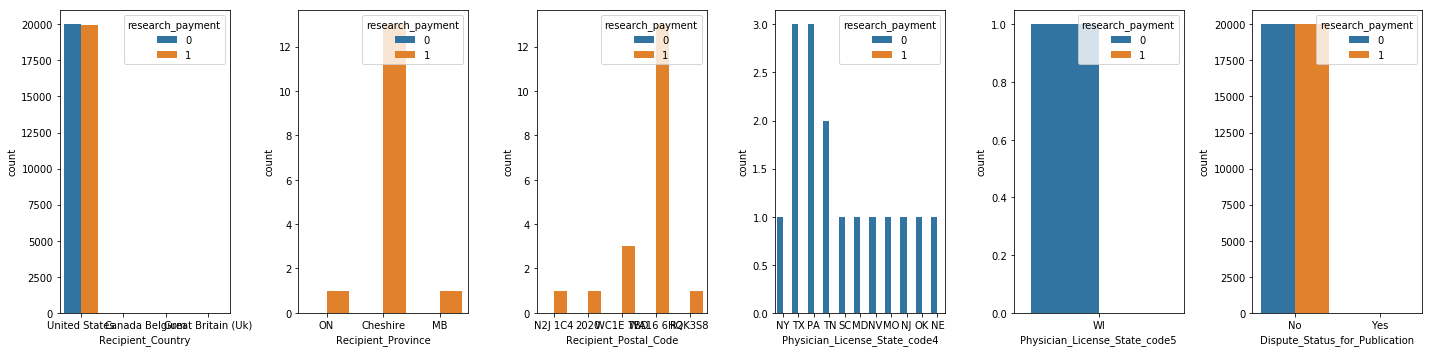

In [9]:
cols_drop = []
for v in df.columns.values[:-1]:
    for i in range(2):
        if len(df[df['research_payment'] == i][v].unique()) == 1:
            if v not in cols_drop: cols_drop.append(v)

                
fig, ax = plt.subplots(1, len(cols_drop), figsize = (20, 5))
i=0
for v in cols_drop:
    sns.countplot(v, hue='research_payment', data = df, ax = ax[i])
    i+=1

plt.tight_layout()

In [10]:
df.drop(cols_drop, axis=1, inplace=True)

#### Sparse Variables

A big portion of our features don't have any data for one of the targets. 

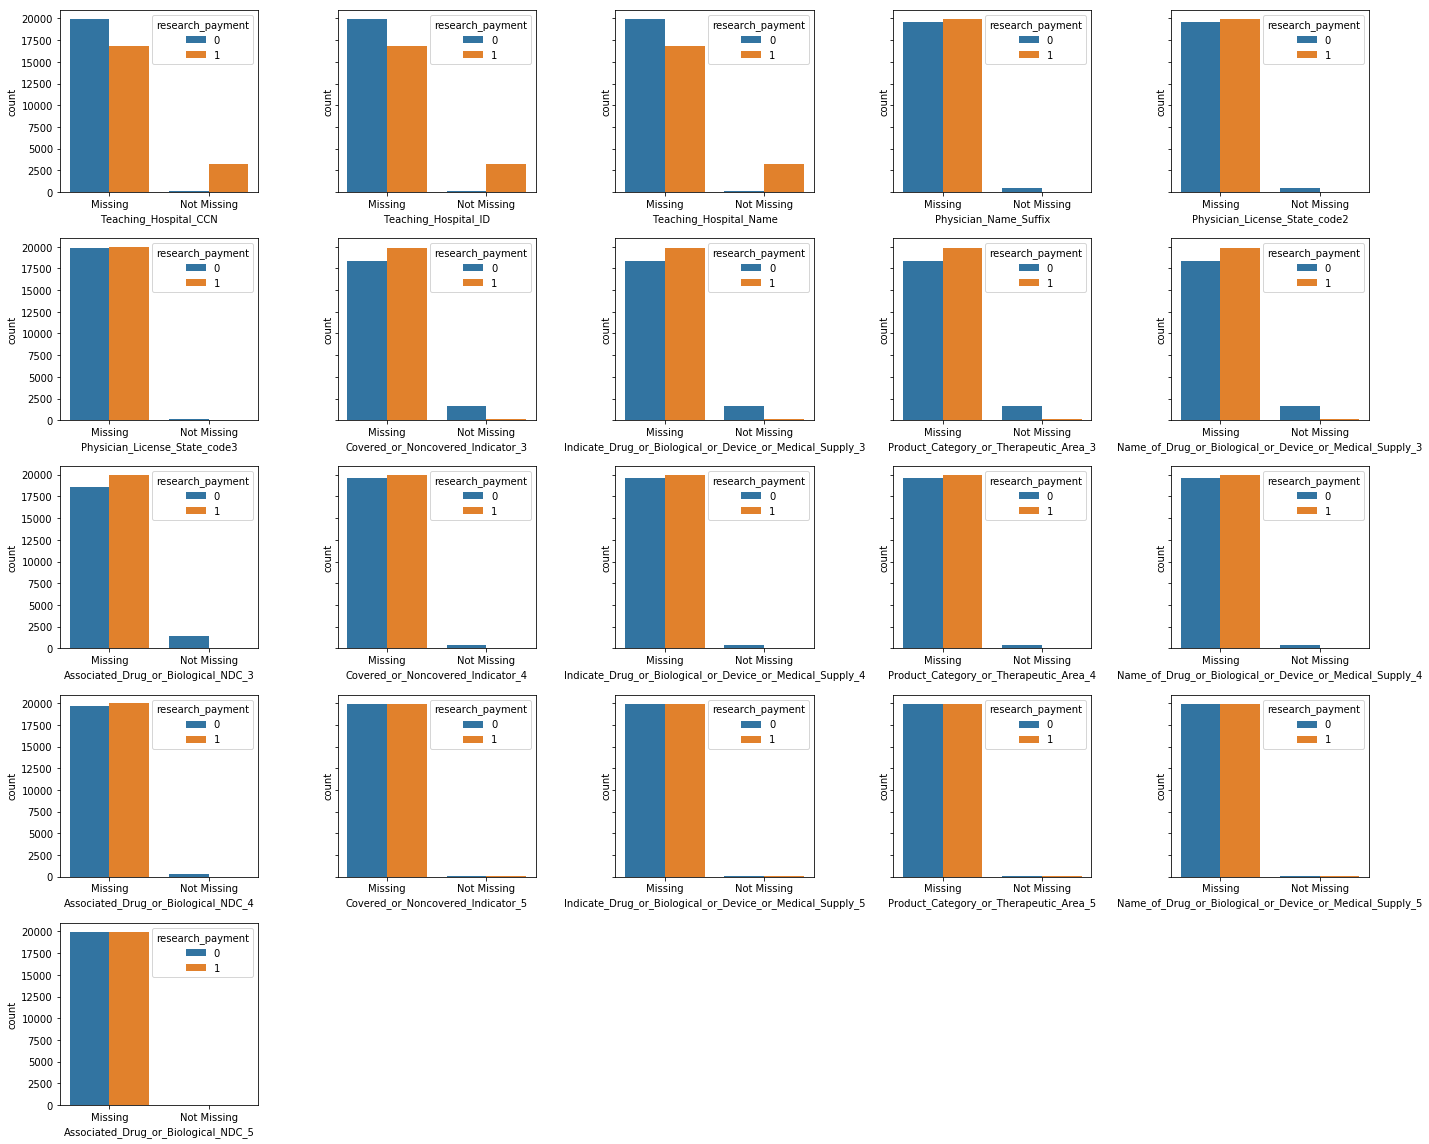

In [11]:
df_missing = df.copy()
for c in df_missing.columns[:-1]:
    df_missing[c] = np.where(df_missing[c].isnull(), 'Missing', 'Not Missing')

fig, ax = plt.subplots(5, 5, figsize = (20, 16), sharey='row')
cols_drop = []
# axis indicators
i = 0
j = 0

for v in df_missing.columns.values[:-1]:
    if df_missing[df_missing[v] == 'Missing'].shape[0] > (df_missing.shape[0] * 0.9):
        sns.countplot(v, hue='research_payment', data = df_missing, ax=ax[j, i])
        cols_drop.append(v)
        # increment axis
        i += 1
        if i == 5: j += 1; i = 0
        
        
fig.delaxes(ax[4, 1])
fig.delaxes(ax[4, 2])
fig.delaxes(ax[4, 3])
fig.delaxes(ax[4, 4])
plt.tight_layout()
plt.show()

In [12]:
df.drop(cols_drop, axis=1, inplace=True)

####  Leaky Variables

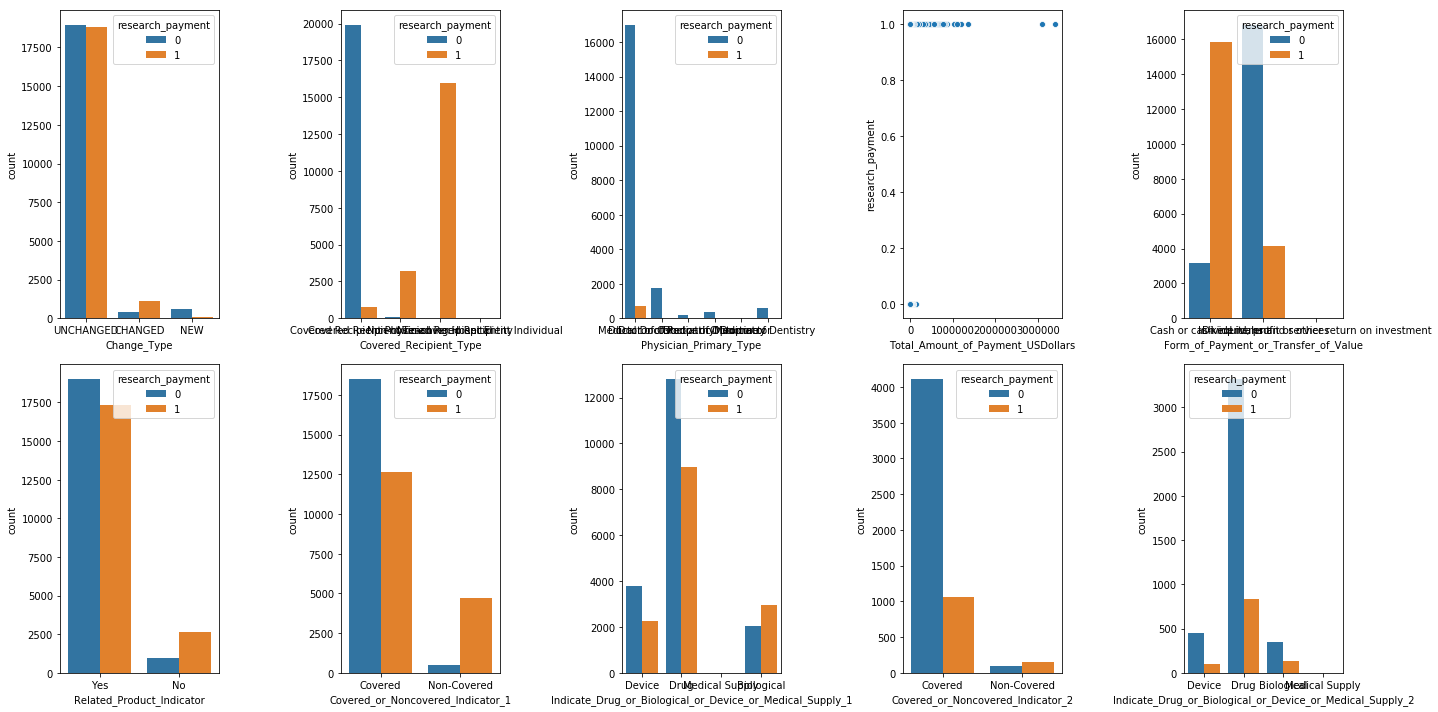

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
i = 0
j = 0

obs_vars = []

for c in df.columns.values[:-1]:
    if df[c].dtype == 'float64':
        sns.scatterplot(x=c, y='research_payment', data=df, ax=ax[j, i])
        i+=1
        obs_vars.append(c)
        if i == 5: j+=1; i=0
    elif (len(df[c].unique()) <= 10) & (df[c].dtype == object):
        sns.countplot(x=c, hue='research_payment', data=df, ax=ax[j, i])
        i+=1
        obs_vars.append(c)
        if i == 5: j+=1; i=0
        
        
plt.tight_layout()
plt.show()

Judging by the plots above, the variables Covered_Recipient_Type and all the Physician variables could be leaking the target. It's important to investigate these further before proceeding.

**Covered_Recipient_Type**

In [14]:
df.groupby(['research_payment', 'Covered_Recipient_Type']).size().reset_index()

,research_payment,Covered_Recipient_Type,0
0,0,Covered Recipient Physician,19933
1,0,Covered Recipient Teaching Hospital,67
2,1,Covered Recipient Physician,778
3,1,Covered Recipient Teaching Hospital,3228
4,1,Non-covered Recipient Entity,15976
5,1,Non-covered Recipient Individual,18


Given that the proportions are very different for each of our targets, this raises further suspicions. General payments are only made to covered recipients so we can remove this variable as it's better to be safe than sorry. 

In [15]:
df.drop('Covered_Recipient_Type', axis=1, inplace=True)

**Physician Variables**

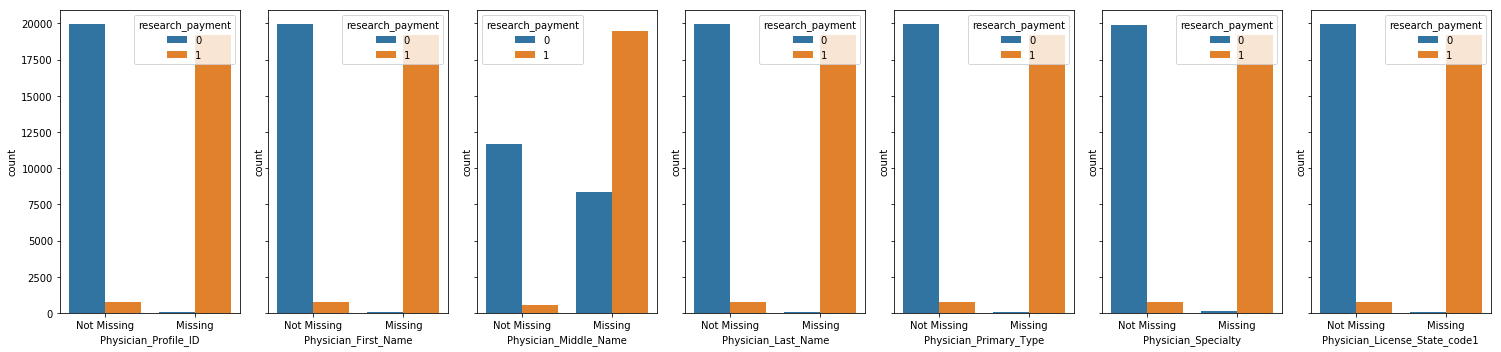

In [16]:
physician_vars = ['Physician_Profile_ID', 'Physician_First_Name', 'Physician_Middle_Name', 'Physician_Last_Name',
                  'Physician_Primary_Type', 'Physician_Specialty', 'Physician_License_State_code1']

fig, ax = plt.subplots(1, 7, figsize=(21, 5), sharey='row')
i = 0

for v in physician_vars:
    sns.countplot(np.where(df[v].notnull(), 'Not Missing', 'Missing'), hue=df['research_payment'], ax=ax[i])
    ax[i].set_xlabel(v)
    i+=1
    
plt.tight_layout()

They all seem to be leaking the target, so we should drop them just to be safe. 

In [17]:
df.drop(physician_vars, axis=1, inplace=True)

**Form_of_Payment_or_Transfer_of_Value**

In [18]:
df.groupby(['research_payment', 'Form_of_Payment_or_Transfer_of_Value']).size().reset_index()

,research_payment,Form_of_Payment_or_Transfer_of_Value,0
0,0,Cash or cash equivalent,3165
1,0,"Dividend, profit or other return on investment",1
2,0,In-kind items and services,16834
3,1,Cash or cash equivalent,15834
4,1,In-kind items and services,4166


Again, the proportions are very different for each payment type and it seems to be very heavily correlated with the target but due to the nature of the variable we conclude that it doesn't leak the target. 

#### Irrelevant Variables

After a quick scan of the remaining variables, we can remove those that don't or at least shouldn't have anything to do with the target. 

In [19]:
cols_drop = ['Recipient_Primary_Business_Street_Address_Line2']
df.drop(cols_drop, axis=1, inplace=True)
obs_vars.append(cols_drop)

#### Remaining Variables

In [20]:
obs_vars.append('research_payment')
unobs_vars = [x for x in df.columns.values if x not in obs_vars]

In [21]:
len(unobs_vars)

16

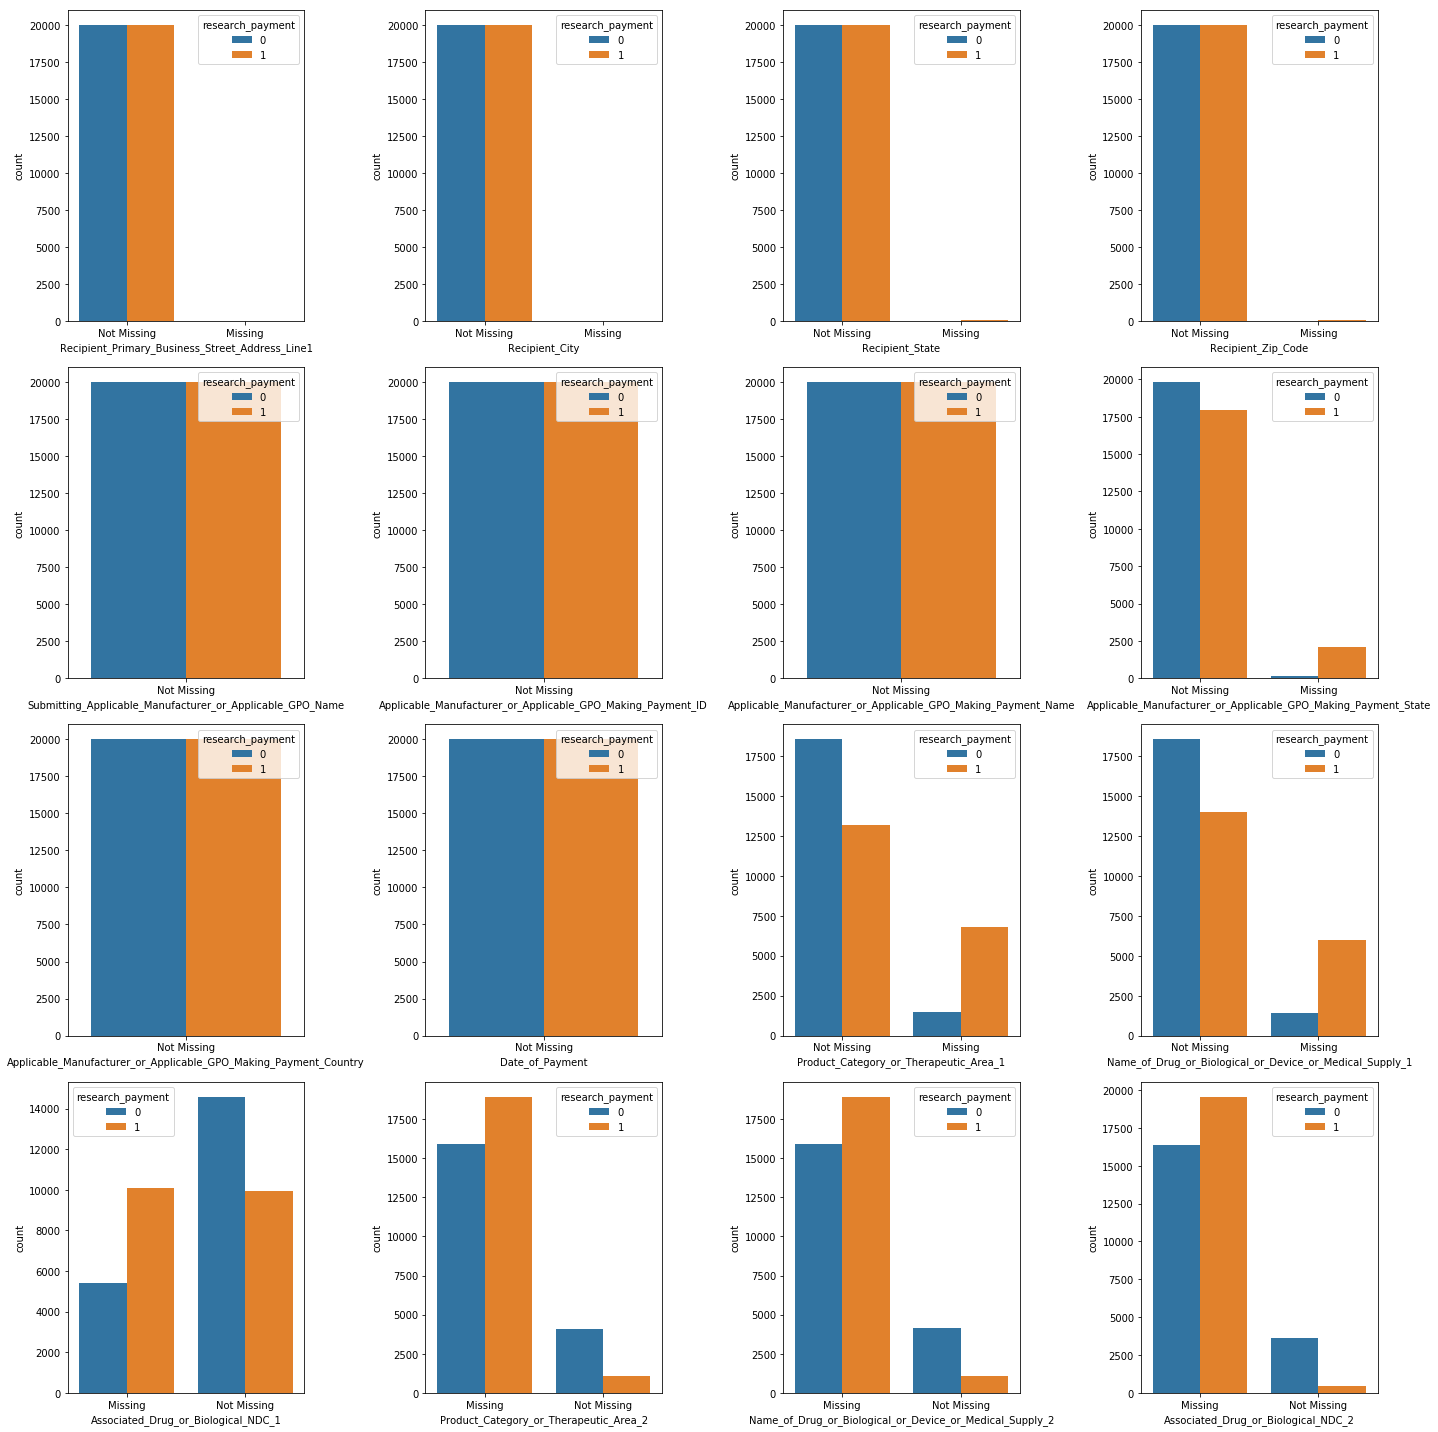

In [22]:
fig, ax= plt.subplots(4, 4, figsize=(20, 20))
i=0
j=0

for v in unobs_vars:
    sns.countplot(np.where(df[v].notnull(), 'Not Missing', 'Missing'), hue=df['research_payment'], ax=ax[j, i])
    ax[j, i].set_xlabel(v)
    i+=1
    if i == 4: j+=1;i=0
    
plt.tight_layout()

#### Renaming our Variables

In [23]:
df = df_rename(df)

## Task 2: Preprocessing and baseline model

For the simple minimum viable model, we've decided to do logistic regression with a very limited number of features. The filter we've applied to features is the following (those are very "harsh" filters but again, this is a baseline model).
* Drop all features with more than 10% missing data (considered "sparse")
* Drop all categorical features with too many categories since we're going to one-hot encode them. We've chosen 200 (1% of the number of data points) as a threshold
* Drop the date feature as it's not in the appropriate format yet. 

In [24]:
cols_drop2 = list(df.columns[df.isnull().sum() > 0.1*df.shape[0]])
cats = df.columns[df.dtypes == object]
cols_drop2.extend(cats[df[cats].nunique() > 0.01*df.shape[0]])
cols_drop2.append('payment_date')
df2 = df.drop(set(cols_drop2), axis=1)
df2.columns

Index(['Change_Type', 'state', 'paying_GPO_state', 'paying_GPO_country',
       'payment_amount', 'payment_form', 'Related_Product_Indicator',
       'product1_covered', 'research_payment'],
      dtype='object')

As we can see, we're left with only a few features, only one of which is continuous. We can now set up a baseline model, with basic preprocessing: we're only going to one-hot encode the categorical variables.

We assign the "missing" category to missing values in categorical variables (such treatment normally shouldn't be done on X directly, but here it doesn't imply data leakage so it's OK). No treatment is needed for the continuous variable since it has no missing value. We then split training and test set.

We also need to change y to -1 and 1.

In [81]:
X = df2.drop('research_payment', axis=1)
y = df2['research_payment']

X_cats = X.columns[X.dtypes == object].tolist()
dict_missing = {i: 'Missing' for i in X_cats}
X.fillna(dict_missing, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_cats = X.dtypes == object

In [90]:
ohe = OneHotEncoder(handle_unknown = 'ignore')
logr = LogisticRegression(C=10000000)
prep = ColumnTransformer([("one-hot encoding", ohe, X_cats), ('pt', 'passthrough', ~X_cats)])
pipe = Pipeline([('preprocessing', prep), ('logreg', logr)])
np.mean(cross_val_score(pipe, X_train, y_train, cv=10, scoring='roc_auc'))

TypeError: __init__() got an unexpected keyword argument 'categories'

In [83]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8405

In [84]:
cols = pipe.named_steps['preprocessing'].named_transformers_['one-hot encoding'].get_feature_names().tolist() + X_cats[X_cats == False].index.tolist()
fig, ax = plt.subplots(1, 1, figsize=(25, 8))
plt.xticks(rotation='vertical')
sns.barplot(x=cols, y=pipe.named_steps['logreg'].coef_[0])
plt.show()

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

In [88]:
pipe.named_steps['preprocessing'].named_transformers_['one-hot encoding'].get_feature_names

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

## Task 3: Feature Engineering

Building on a lot of the feature analysis done above, we can engineer our variables with a finer detail to enhance our model performance. 

In [29]:
for v in ['paying_GPO_ID', 'payment_amount', 'research_payment']:
    df[v] = pd.to_numeric(df[v])
df['payment_date'] = pd.to_datetime(df.payment_date)

In [30]:
df.head(2)

,Change_Type,address,city,state,zip_code,submitting_GPO_name,paying_GPO_ID,paying_GPO_name,paying_GPO_state,paying_GPO_country,payment_amount,payment_date,payment_form,Related_Product_Indicator,product1_covered,product1_type,product1_category,product1_name,product1_associated,product2_covered,product2_type,product2_category,product2_name,product2_associated,research_payment
0,UNCHANGED,4921 PARKVIEW PL,SAINT LOUIS,MO,63110-1032,Mevion_Medical_Systems_Inc,100000011220,Mevion_Medical_Systems_Inc,MA,United States,23.29,2017-12-19,Cash or cash equivalent,Yes,Covered,Device,Proton Therapy for cancer treatment,PTS250,NaN,NaN,NaN,NaN,NaN,NaN,0
1,UNCHANGED,1482 E WILLIAMS FIELD RD,GILBERT,AZ,85295,Bovie Medical Corporation,100000046274,Bovie Medical Corporation,FL,United States,35.70,2017-07-25,Cash or cash equivalent,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Although the values of a lot of our variables provide little insight, the fact that they're non empty may be more useful.

**Zip-Code**

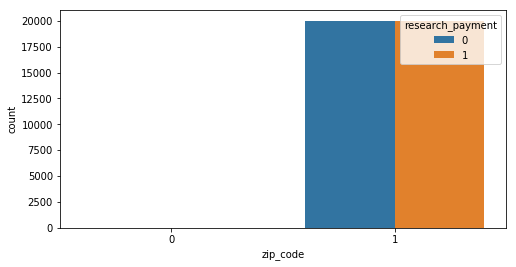

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.countplot(np.where(df.zip_code.notnull(), 1, 0), hue=df['research_payment'], ax=ax)
ax.set_xlabel('zip_code')
plt.show()

Zip-code has a unique value for almost all observations so it's safe to drop it. 

In [32]:
df.drop(['zip_code'], axis=1, inplace=True)

For the remaining text variables, it might be a good idea to set all their values to lower case before proceeding in case there are any duplicates that have been skipped. 

In [33]:
for c in df.columns.values[:-1]:
    if df[c].dtype == object:
        df[c] = df[c].str.lower()

**Address**

Almost every observation has a different address, so on first glance this might not be a very useful variable.

In [34]:
df.groupby(['research_payment', 'address']).size().reset_index().iloc[np.r_[0:2, -2:0]]

,research_payment,address,0
0,0,1 andrew ct,1
1,0,1 associate dr,1
23245,1,yale university school of medicinetreasury ope...,1
23246,1,york st ynhh smilow cancer center,1


It might be worth extracting the notable parts of each address line by looking for some keywords, e.g university, laboratory, medical, hospital etc. 

We'll map all address to either a hospital/lab/uni or other. 

In [35]:
# university
df['address'] = np.where(df.address.str.contains('uni|depart|medic|lab|resear|foundat', regex=True), 'university', df.address)
# hospital
df['address'] = np.where(df.address.str.contains('hosp|clinic', regex=True), 'hospital', df.address)
# po box
df['address'] = np.where(df.address.str.contains('box', regex=True), 'pobox', df.address)
# other
df['address'] = np.where(df.address.str.contains('hosp|lab|uni|box', regex=True), df.address, 'other')

In [36]:
df.groupby(['research_payment', 'address']).size().reset_index()

,research_payment,address,0
0,0,hospital,201
1,0,other,18918
2,0,pobox,222
3,0,university,659
4,1,hospital,160
5,1,other,18200
6,1,pobox,608
7,1,university,1032


**City**

In [37]:
print('The city variable has {} unique values.'.format(len(df.city.unique())))

The city variable has 3315 unique values.


In [38]:
df.groupby(['research_payment', 'city']).size().reset_index()[df.groupby(['research_payment', 'city']).size().reset_index()[0] >= (df.shape[0] / 200)]

,research_payment,city,0
1239,0,houston,296
1877,0,new york,311
3115,1,atlanta,258
3192,1,boston,420
3282,1,chicago,303
3348,1,dallas,496
3601,1,houston,418
3750,1,los angeles,345
3823,1,miami,241
3893,1,nashville,227


It might be beneficial for us to keep the most popular cities and group all the others in a common category as the number of different categories certainly doesn't help our model. 

In [39]:
popular_cities = df.groupby(['research_payment', 'city']).size().reset_index()[df.groupby(['research_payment', 'city']).size().reset_index()[0] >= (df.shape[0] / 200)]['city'].unique()
# remap the city variable
df['city'] = np.where(np.isin(df.city, popular_cities), df.city, 'other')

In [40]:
print('The variable city now has {} unique values.'.format(len(df.city.unique())))

The variable city now has 12 unique values.


**State**

In [41]:
print('The variable State has {} unique values.'.format(len(df.state.unique())))

The variable State has 53 unique values.


Although there are not as many categories as in the previous variable, this might also be problematic. We can try to visualize the proportions in case it helps. 

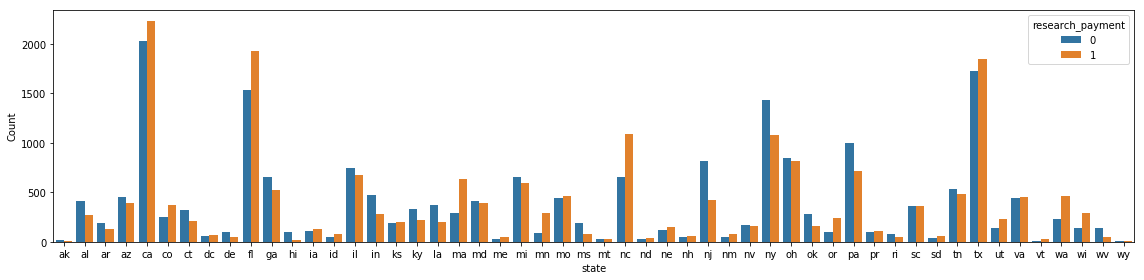

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.barplot(x='state', y=0, hue='research_payment', data=df.groupby(['research_payment', 'state']).size().reset_index(), ax = ax)
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

We could try Mean Encoding that may deal with that appropriately.

In [43]:
df['state'].fillna('missing', inplace=True)
df['state_enc'] = TargetEncoder().fit_transform(pd.DataFrame(df['state']), df['research_payment'].values)

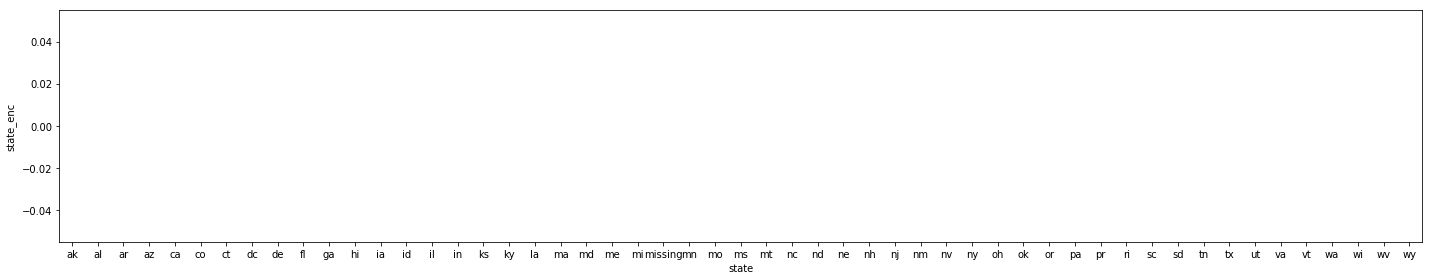

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(20,4))
sns.barplot(x='state', y='state_enc', data=df.groupby('state')['state_enc'].first().reset_index(), ax=ax, color='lightblue')
df.drop('state_enc', axis=1, inplace=True)
plt.tight_layout()
plt.show()

**GPO Names**

submitting_GPO_name and paying_GPO_name are very often the same; are the observations where the two are different indicative of anything? 

AttributeError: Unknown property labels

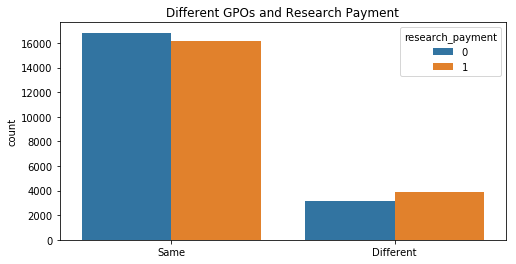

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.countplot(np.where(df.submitting_GPO_name != df.paying_GPO_name, 'Different', 'Same'), hue=df['research_payment'])
ax.set_title('Different GPOs and Research Payment')
plt.xticks([0,1], labels=['Same', 'Different'])
plt.tight_layout()
plt.show()

It seems that the majority of payments have the same submitting and paying GPO; it also looks that the proportions are somewhat different for the two. 

In [47]:
df['different_GPO'] = np.where(df.submitting_GPO_name != df.paying_GPO_name, 'Different', 'Same')

# drop the original variables
df.drop(['submitting_GPO_name', 'paying_GPO_name', 'paying_GPO_ID'], axis=1, inplace=True)

**Paying GPO State and Country**

KeyError: 'paying_GPO_country'

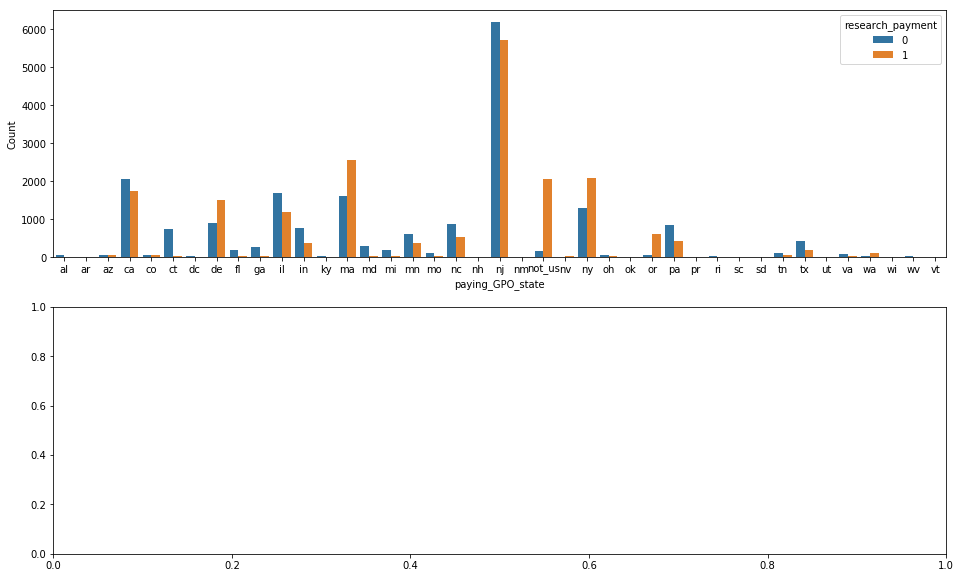

In [48]:
df.paying_GPO_state.fillna('not_us', inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(16, 10))
sns.barplot(x='paying_GPO_state', y=0, hue='research_payment', data=df.groupby(['research_payment', 'paying_GPO_state']).size().reset_index(), ax = ax[0])
ax[0].set_ylabel('Count')
sns.barplot(x='paying_GPO_country', y=0, hue='research_payment', data=df.groupby(['research_payment', 'paying_GPO_country']).size().reset_index(), ax = ax[1])
ax[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [49]:
df.drop('paying_GPO_country', axis=1, inplace=True)

KeyError: "['paying_GPO_country'] not found in axis"

By incorporating the information provided in paying_GPO_country in paying_GPO_state, we can drop the country variable. We can now treat the paying GPO state variable the same way we did the original state variable, target encoding. 

**Payment Amount**

Our only continuous variable, it's important to see whether it needs scaling or any other transformation. 

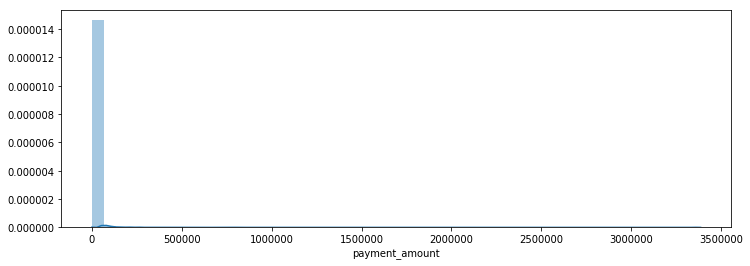

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.distplot(df.payment_amount, ax=ax)
plt.show()

A log transformation might fix the skewness. 

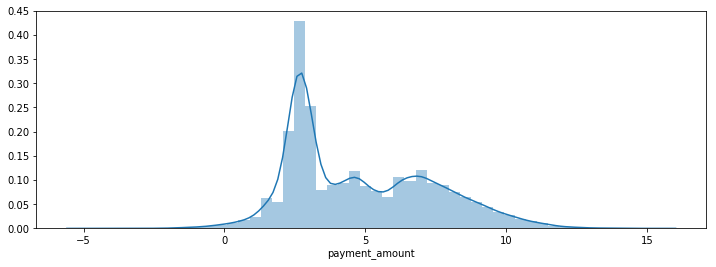

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.distplot(np.log(df.payment_amount))
plt.show()

Although the transformation doesn't take care of the skewness completely, as there still seems to be a positive skewness in our data, we can still proceed. 

In [52]:
df['log_payment_amount'] = np.log(df.payment_amount)
# drop the original
df.drop('payment_amount', axis=1, inplace=True)

**Payment Form**

In [53]:
df.groupby(['research_payment', 'payment_form']).size().reset_index()

,research_payment,payment_form,0
0,0,cash or cash equivalent,3165
1,0,"dividend, profit or other return on investment",1
2,0,in-kind items and services,16834
3,1,cash or cash equivalent,15834
4,1,in-kind items and services,4166


In [54]:
df['cash_payment'] = np.where(df.payment_form == 'cash or cash equivalent', 'cash', 'other')
# drop the original
df.drop('payment_form', axis=1, inplace=True)

**Related Product Indicator**

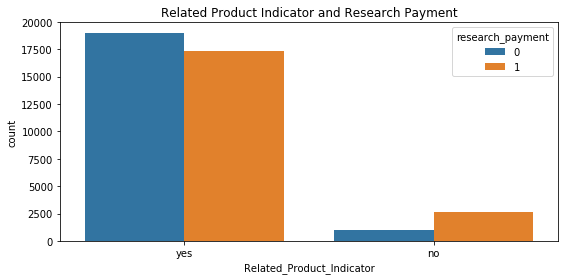

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.countplot(df.Related_Product_Indicator, hue=df['research_payment'])
ax.set_title('Related Product Indicator and Research Payment')
plt.tight_layout()
plt.show()

**Product 1 Variables**

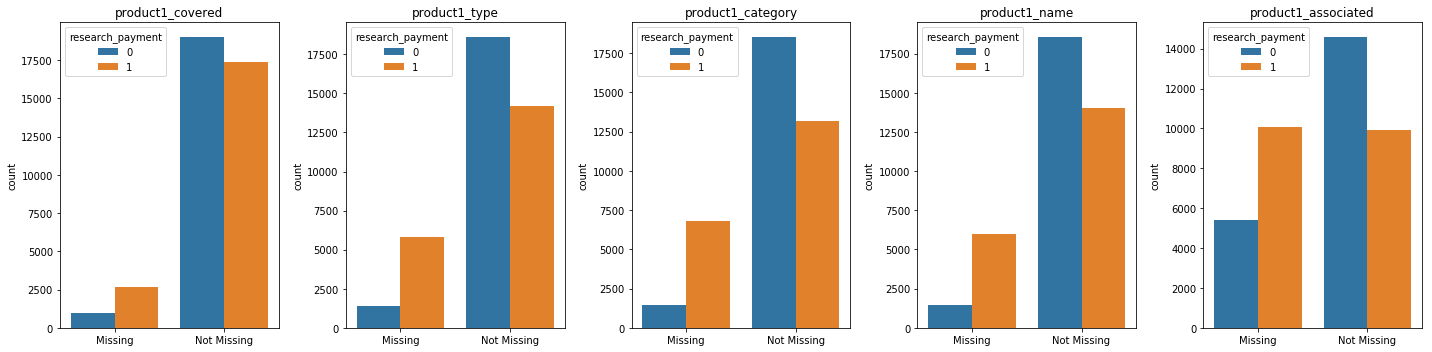

In [56]:
p1_vars = ['product1_covered', 'product1_type', 'product1_category', 'product1_name', 'product1_associated']
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for i in range(len(p1_vars)):
    sns.countplot(np.where(df[p1_vars[i]].isnull(), 0, 1), hue=df['research_payment'], ax=ax[i])
    ax[i].set_title(p1_vars[i])
    ax[i].set_xticklabels(['Missing', 'Not Missing'])
    
plt.tight_layout()
plt.show()

In [57]:
df.product1_covered.fillna('missing', inplace=True)
df.groupby(['research_payment', 'product1_covered']).size().reset_index()

,research_payment,product1_covered,0
0,0,covered,18491
1,0,missing,992
2,0,non-covered,517
3,1,covered,12671
4,1,missing,2636
5,1,non-covered,4693


In [58]:
df.product1_type.fillna('missing', inplace=True)
df.groupby(['research_payment', 'product1_type']).size().reset_index()

,research_payment,product1_type,0
0,0,biological,2026
1,0,device,3767
2,0,drug,12799
3,0,medical supply,17
4,0,missing,1391
5,1,biological,2951
6,1,device,2242
7,1,drug,8965
8,1,medical supply,2
9,1,missing,5840


In [59]:
df.product1_type.fillna('missing', inplace=True)
df.groupby(['research_payment', 'product1_category']).size().reset_index().iloc[np.r_[0:2, -2:0]]

,research_payment,product1_category,0
0,0,1,12
1,0,ablation,4
892,1,woundcare,1
893,1,x-ray,2


This feature also requires further parsing.

In [60]:
df['product1_category'] = df['product1_category'].str.split(' ').str[0]

We keep the most popular categories and group the rest as 'other'. 

In [61]:
p1_cats = df.groupby(['research_payment', 'product1_category']).size().reset_index()[df.groupby(['research_payment', 'product1_category']).size().reset_index()[0] > 200]['product1_category'].unique()

# remap p1 category
df['product1_category'] = np.where(np.isin(df.product1_category, p1_cats), df.product1_category, 'other')

In [62]:
df.product1_name.fillna('missing', inplace=True)

df.groupby(['research_payment', 'product1_name']).size().reset_index().iloc[np.r_[0:2, -2:0]]

,research_payment,product1_name,0
0,0,(810) chenodal,1
1,0,(815) thiola,4
2595,1,zykadia,5
2596,1,zytiga,10


In [63]:
df.drop(['product1_name', 'product1_associated'], axis=1, inplace=True)

**Product 2 Variables**

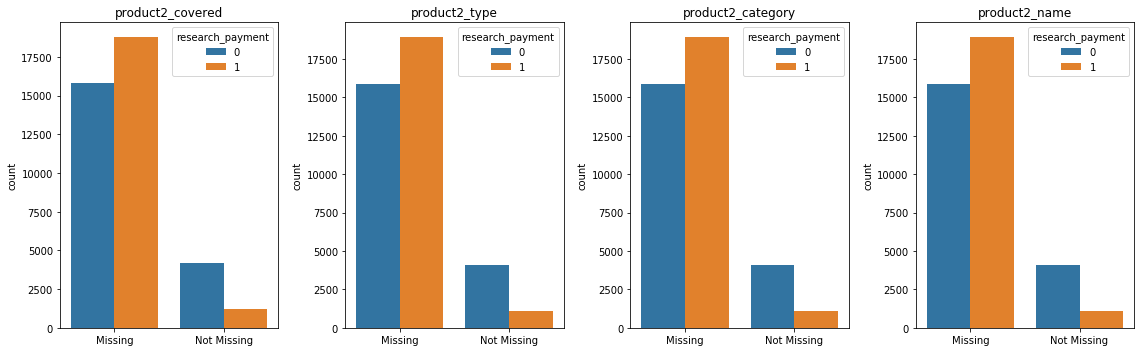

In [64]:
p2_vars = ['product2_covered', 'product2_type', 'product2_category', 'product2_name']
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

for i in range(len(p2_vars)):
    sns.countplot(np.where(df[p2_vars[i]].isnull(), 0, 1), hue=df['research_payment'], ax=ax[i])
    ax[i].set_title(p2_vars[i])
    ax[i].set_xticklabels(['Missing', 'Not Missing'])
    
plt.tight_layout()
plt.show()

In [65]:
df['p2_missing'] = np.where(df.product2_covered.isnull(), 'missing', 'not_missing')

# drop the original
df.drop(p2_vars, axis=1, inplace=True)

**Payment Date**

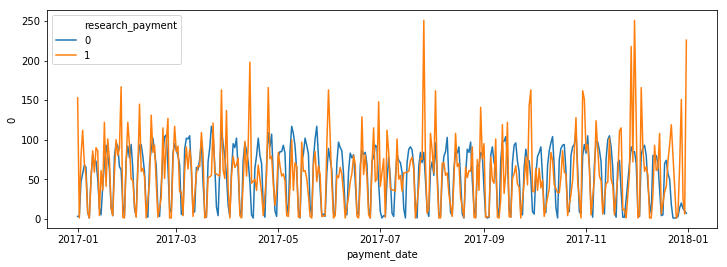

In [66]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
sns.lineplot(x='payment_date', y=0, hue='research_payment', data=df.groupby(['research_payment', 'payment_date']).size().reset_index())
plt.show()

To get as much information as possible from the payment date variable, we can extract the month, year, day of the month and weekday. 

In [67]:
# day of the week
df['payment_weekday'] = df.payment_date.dt.weekday

# month
df['payment_month'] = df.payment_date.dt.month

# day of year
df['payment_dayofyear'] = df.payment_date.dt.dayofyear

# drop the original
df.drop('payment_date', axis=1, inplace=True)

In [68]:
df.head(2)

,Change_Type,address,city,state,paying_GPO_state,Related_Product_Indicator,product1_covered,product1_type,product1_category,product2_associated,research_payment,different_GPO,log_payment_amount,cash_payment,p2_missing,payment_weekday,payment_month,payment_dayofyear
0,unchanged,other,other,mo,ma,yes,covered,device,other,NaN,0,Same,3.148024,cash,missing,1,12,353
1,unchanged,other,other,az,fl,no,missing,missing,other,NaN,0,Same,3.575151,cash,missing,1,7,206


## Task 4: Any model


The models we've decided to use for this part are the following: 
* Ridge Logistic regression, as an extension of the baseline model
* Kernelized SVM (RBF Kernel) 
* Random Forests
* XGBoost

We will do some preprocessing for Logistic Regression, SVM and Random Forests using Column Transformers, which we'll include in a pipeline. Let's first get out training and test sets: 

In [72]:
# get X and y
y = df.research_payment
X = df.drop('research_payment', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y)

We have three column transformers:
- One for your categorical variables that need to be one hot encoded.
- One for the categorical variables that need to be mean encoded.
- And one for our one and only continuous variable.

### Preprocessing

We have three column transformers:
- One for your categorical variables that need to be one hot encoded.
- One for the categorical variables that need to be mean encoded (State and paying GPO state)
- And one for our continuous and ordinal variables (payment amount, month and day of year): we'll apply a standard scaler. This scaler will only be applied for models that are sensitive to scaling: LogReg and SVM. 

Please note that we don't have to worry about imputing any missing values, because our previous treatment has left no missing value at all. 

In [ ]:
ohe = OneHotEncoder(categories="auto", handle_unknown = 'ignore')
rsc = RobustScaler()
menc = TargetEncoder()
Xt_cat = X_train.dtypes == object
Xt_cont = ~Xt_cat
Xt_mean = X_train.columns.isin(['state', 'paying_GPO_state'])
Xt_cat = np.logical_and(Xt_cat, Xt_mean)

prepsc = ColumnTransformer([('one-hot encoding', ohe, Xt_cat), ('mean encoding', menc, Xt_mean), ('scaling', rsc, Xt_cont)])
prepnsc = ColumnTransformer([('one-hot encoding', ohe, Xt_cat), ('mean encoding', menc, Xt_mean), ('pt', 'passthrough', Xt_cont)])

# CHANGE GRIDSEARCH PARAMS

### Ridge Logistic Regression

We start with Logistic Regression. We apply a penalty this time (L2, because we have no reason to think that the solution is sparse). The grid-search is done on C. 

In [ ]:
logr = LogisticRegression()
pipe_logr = Pipeline([('preprocessing', prepsc), ('logr', logr)])
param_grid_logr = {'logr__C': np.logspace(-3, 2, 2)}

grid_logr = GridSearchCV(pipe_logr, param_grid_logr, cv=5)
_ = grid_logr.fit(X_train, y_train)

Let's display a basic evaluation of the model: the best score found in the grid search (the score being precision) and the score curve depending on C.

In [ ]:
s_logr = grid_logr.best_score_
print("Best score for Logistic Regression: " + str(s_logr))

In [ ]:
results_logr = pd.DataFrame(grid_logr.cv_results_)
results_logr.plot('param_logr__C', 'mean_train_score')
results_logr.plot('param_logr__C', 'mean_test_score', ax=plt.gca())
plt.legend()
plt.xscale("score")
plt.xlabel("C")
plt.title("Logistic Regression")
plt.show()

As we can see, 

### Kernelized SVM

We now do Kernelized SVM. We decided to do a Grid Search on both important parameters, C (penalty) and gamma (rbf kernel coefficient).

In [ ]:
svc = SVC()
pipe_svc = Pipeline([('preprocessing', prepsc), ('svc', svc)])
param_grid_svc = {'svc__C': np.logspace(-3, 2, 2),
                   'svc__gamma': np.logspace(-3, 2, 2)}

grid_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5)
_ = grid_svc.fit(X_train, y_train)

Let's display a basic evaluation of the model: the best score found in the grid search (the score being precision) and the score matrix depending on C and gamma. 

In [ ]:
s_svc = grid_svc.best_score_
print("Best score for Kernelized SVM: " + str(s_svc))

In [ ]:
res = pd.pivot_table(pd.DataFrame(grid_svc.cv_results_),
                     values='mean_test_score', index='param_svc_C', 
                     columns='param_svc__gamma')
plt.figure(figsize = (10,7))
plt.imshow(res)
plt.colorbar()
Cs = param_grid_svc['svc__C']
gammas = np.array(param_grid_en['svc__gamma'])
plt.xlabel("gamma")
plt.ylabel("C")
plt.yticks(range(len(Cs)), ["{:.4f}".format(a) for a in Cs])
plt.xticks(range(len(gammas)), gammas);

### Random Forests

For random forests, we first try a warm-start with default parameters to determine how many classifiers we should use for the model. We set max-depth now to limit computation time and the size of the model: we arbitrarily decide on a max-depth of 5.

In [75]:
rf = RandomForestClassifier(warm_start=True, max_depth=5)
X_trainp = prepnsc.fit_transform(X_train)
X_testp = prepnsc.fit_transform(X_test)

estimator_range = range(1, 100, 5)
train_scores = []
test_scores = []
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_trainp, y_train)
    train_scores.append(rf.score(X_trainp, y_train))
    test_scores.append(rf.score(X_testp, y_test))
    
plt.plot(train_scores)
plt.plot(test_scores)
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 17 but corresponding boolean dimension is 8

We then do the Grid-Search on max-features: we try from 1 to 6. We have 17 features and we know max-features should be around the square root of that, which is around 4. 

In [76]:
rf = RandomForestClassifier(max_depth = 5, n_estimators = XXX)
pipe_svc = Pipeline([('preprocessing', prepnsc), ('rf', rf)])
param_grid_svc = {'rf__max_features': range(1,7)}

grid_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5)
_ = grid_svc.fit(X_train, y_train)

NameError: name 'XXX' is not defined

In [ ]:
s_rf = grid_rf.best_score_
print("Best score for Random Forests: " + str(s_rf))

In [ ]:
results_rf = pd.DataFrame(grid_logr.cv_results_)
results_rf.plot('param_rf__max_features', 'mean_train_score')
results_rf.plot('param_rf__max_features', 'mean_test_score', ax=plt.gca())
plt.legend()
plt.xscale("score")
plt.xlabel("max_features")
plt.title("Random Forests")
plt.show()

### XGBoost

Finally, we try an XGBoost model. The only change we'd have done with preprocessing would have been to remove the treatment of missing values, but we don't have missing values in the first place because they were all in categorical features and we imputed them as "missing". So we use the same preprocessing again. 

We set the number of classifiers to XXX. We set max_depth to 5 again.

We then do the same Grid-Search on max-features as with random forests.

In [79]:
xgb = XGBClassifier(max_depth = 5, n_estimators = XXX)
pipe_xgb = Pipeline([('preprocessing', prepnsc), ('xgb', xgb)])
param_grid_xgb = {'xgb__max_features': range(1,7)}

grid_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5)
_ = grid_xgb.fit(X_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Change_Type, address, city, state, paying_GPO_state, Related_Product_Indicator, product1_covered, product1_type, product1_category, product2_associated, different_GPO, cash_payment, p2_missing

In [ ]:
s_xgb = grid_xgb.best_score_
print("Best score for XGBoost: " + str(s_xgb))

In [ ]:
results_xgb = pd.DataFrame(grid_xgb.cv_results_)
results_xgb.plot('param_xgb__max_features', 'mean_train_score')
results_xgb.plot('param_xgb__max_features', 'mean_test_score', ax=plt.gca())
plt.legend()
plt.xscale("score")
plt.xlabel("max_features")
plt.title("XGBoost")
plt.show()